# Load Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# columns correspond to unitigs so we must transpose this table
def load_unitig_data(path) -> pd.DataFrame:
    sr = pd.read_csv(path, sep=' ')
    sr.set_index('pattern_id',inplace=True)
    return sr.T[1:]

azm_sr = load_unitig_data("azm_sr_gwas_filtered_unitigs.Rtab")
cfx_sr = load_unitig_data("cfx_sr_gwas_filtered_unitigs.Rtab")
cip_sr = load_unitig_data("cip_sr_gwas_filtered_unitigs.Rtab")

metadata = pd.read_csv('metadata.csv')
metadata.set_index('Sample_ID',inplace=True)


In [2]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3786 entries, ERR1549286 to ERR2172354
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            3536 non-null   float64
 1   Country         3785 non-null   object 
 2   Continent       3785 non-null   object 
 3   Beta.lactamase  1927 non-null   object 
 4   Azithromycin    3480 non-null   object 
 5   Ciprofloxacin   3129 non-null   object 
 6   Ceftriaxone     3436 non-null   object 
 7   Cefixime        3405 non-null   object 
 8   Tetracycline    1472 non-null   object 
 9   Penicillin      1465 non-null   object 
 10  NG_MAST         3779 non-null   object 
 11  Group           3786 non-null   int64  
 12  azm_mic         3478 non-null   float64
 13  cip_mic         3088 non-null   float64
 14  cro_mic         3434 non-null   float64
 15  cfx_mic         3401 non-null   float64
 16  tet_mic         1472 non-null   float64
 17  pen_mic         1465 no

In [3]:
metadata.head(5)

,Year,Country,Continent,Beta.lactamase,Azithromycin,Ciprofloxacin,Ceftriaxone,Cefixime,Tetracycline,Penicillin,...,log2_cro_mic,log2_cfx_mic,log2_tet_mic,log2_pen_mic,azm_sr,cip_sr,cro_sr,cfx_sr,tet_sr,pen_sr
Sample_ID,,,,,,,,,,,,,,,,,,,,,
ERR1549286,2015.0,UK,Europe,NaN,>256,NaN,0.016,NaN,NaN,NaN,...,-5.965784,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN
ERR1549290,2015.0,UK,Europe,NaN,>256,NaN,0.004,NaN,NaN,NaN,...,-7.965784,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN
ERR1549291,2015.0,UK,Europe,NaN,>256,NaN,0.006,NaN,NaN,NaN,...,-7.380822,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN
ERR1549287,2015.0,UK,Europe,NaN,>256,NaN,0.006,NaN,NaN,NaN,...,-7.380822,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN
ERR1549288,2015.0,UK,Europe,NaN,>256,NaN,0.008,NaN,NaN,NaN,...,-6.965784,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN


# Null/NA Cleaning in Labels

1. Remove rows with NaN in the labels we are trying to predict: 'azm_sr','cfx_sr', 'cip_sr'

---

Note to Jacob:
If I remove all rows with nulls, then we drop down to ~1k entries. Not ideal. I will remove only the nulls in the target labels. By doing that I was able to preserve ~2800 entries.

Additionally, I can technically replace the nulls in the feature set with averages whether they are continuous or discrete, but since we are going to be building some kind of predictive model later, it would be bad practice to run column averages in df.fillna() before we split our dataset into training and test sets.

Therefore, I am going to split the dataset into a training and test set first.

What do you think?

-Jacob
We could evaluate how to fill the NaN values based on how the data is skewed for each feature we want to predict. 
if skew > 0 -> fill NaN with mean .. there are more 0s than 1s, mean will reflect the distribution of 0s and 1s
else if skew < 0 -> fill NaN with median .. there are more 1s than 0s, using the median ensures our negatively skewed data wont be affected by an uneven distribution of 0s and 1s when we fill it


In [4]:

def impute_cols_by_skew(df, columns):
    for column_name in columns:
        sr_skew = df[column_name].skew()
        impute_value = None
        if sr_skew > 0:
            impute_value = df[column_name].mean()
        elif sr_skew < 0:
            impute_value = df[column_name].median()
        df[column_name].fillna(impute_value, inplace=True)

#metadata.dropna(axis=0, how='any', inplace=True, subset=['azm_sr', 'cfx_sr', 'cip_sr'])

It looks like they're all positively skewed so we can use mean values, lets try continuous for now and see what happens. It was worth trying this though

In [5]:
metadata.head(5)

,Year,Country,Continent,Beta.lactamase,Azithromycin,Ciprofloxacin,Ceftriaxone,Cefixime,Tetracycline,Penicillin,...,log2_cro_mic,log2_cfx_mic,log2_tet_mic,log2_pen_mic,azm_sr,cip_sr,cro_sr,cfx_sr,tet_sr,pen_sr
Sample_ID,,,,,,,,,,,,,,,,,,,,,
ERR1549286,2015.0,UK,Europe,NaN,>256,NaN,0.016,NaN,NaN,NaN,...,-5.965784,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN
ERR1549290,2015.0,UK,Europe,NaN,>256,NaN,0.004,NaN,NaN,NaN,...,-7.965784,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN
ERR1549291,2015.0,UK,Europe,NaN,>256,NaN,0.006,NaN,NaN,NaN,...,-7.380822,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN
ERR1549287,2015.0,UK,Europe,NaN,>256,NaN,0.006,NaN,NaN,NaN,...,-7.380822,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN
ERR1549288,2015.0,UK,Europe,NaN,>256,NaN,0.008,NaN,NaN,NaN,...,-6.965784,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN


# Removing Un-used labels (Ground truth)
2. Removing 'Year', and unimportant labels 'cro_sr', 'tet_sr', 'pen_sr'

In [6]:
useless_columns = ['Year', 'cro_sr', 'tet_sr', 'pen_sr']

metadata.drop(labels=useless_columns, axis=1, inplace=True)

In [7]:
metadata.columns

Index(['Country', 'Continent', 'Beta.lactamase', 'Azithromycin',
       'Ciprofloxacin', 'Ceftriaxone', 'Cefixime', 'Tetracycline',
       'Penicillin', 'NG_MAST', 'Group', 'azm_mic', 'cip_mic', 'cro_mic',
       'cfx_mic', 'tet_mic', 'pen_mic', 'log2_azm_mic', 'log2_cip_mic',
       'log2_cro_mic', 'log2_cfx_mic', 'log2_tet_mic', 'log2_pen_mic',
       'azm_sr', 'cip_sr', 'cfx_sr'],
      dtype='object')

# Remove Duplicates

3. Removing Duplicate entries in the dataframe

In [8]:
metadata.drop_duplicates(inplace=True)

# Cleaning non-numeric entries in numeric fields to NaN.

4. Turn Non Numeric Entries in Numeric Columns into NaN
5. Cast all numeric rows into float32
---


Notes: Turning them into NaN for now. Will engineer values for all NaNs after train and test splits are made

In [9]:
numeric_columns = [
'Azithromycin',
'Ciprofloxacin',
'Ceftriaxone',
'Cefixime',
'Tetracycline',
'Penicillin',
'NG_MAST',
'Group',
'azm_mic',
'cip_mic',
'cro_mic',
'cfx_mic',
'tet_mic',
'pen_mic',
'log2_azm_mic',
'log2_cip_mic',
'log2_cro_mic',
'log2_cfx_mic',
'log2_tet_mic',
'log2_pen_mic'

]

for column in numeric_columns:
    metadata[column] = pd.to_numeric(metadata[column], errors='coerce', downcast="float") #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html

In [10]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3113 entries, ERR1549286 to ERR2172346
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         3112 non-null   object 
 1   Continent       3112 non-null   object 
 2   Beta.lactamase  1561 non-null   object 
 3   Azithromycin    2832 non-null   float32
 4   Ciprofloxacin   2608 non-null   float32
 5   Ceftriaxone     2856 non-null   float32
 6   Cefixime        2811 non-null   float32
 7   Tetracycline    1282 non-null   float32
 8   Penicillin      1274 non-null   float32
 9   NG_MAST         2671 non-null   float32
 10  Group           3113 non-null   float32
 11  azm_mic         2863 non-null   float32
 12  cip_mic         2626 non-null   float32
 13  cro_mic         2858 non-null   float32
 14  cfx_mic         2841 non-null   float32
 15  tet_mic         1284 non-null   float32
 16  pen_mic         1278 non-null   float32
 17  log2_azm_mic    2863 no

In [11]:
metadata.head(10)

,Country,Continent,Beta.lactamase,Azithromycin,Ciprofloxacin,Ceftriaxone,Cefixime,Tetracycline,Penicillin,NG_MAST,...,pen_mic,log2_azm_mic,log2_cip_mic,log2_cro_mic,log2_cfx_mic,log2_tet_mic,log2_pen_mic,azm_sr,cip_sr,cfx_sr
Sample_ID,,,,,,,,,,,,,,,,,,,,,
ERR1549286,UK,Europe,NaN,NaN,NaN,0.016,NaN,NaN,NaN,9768.0,...,NaN,9.000000,NaN,-5.965784,NaN,NaN,NaN,1.0,NaN,NaN
ERR1549290,UK,Europe,NaN,NaN,NaN,0.004,NaN,NaN,NaN,9768.0,...,NaN,9.000000,NaN,-7.965784,NaN,NaN,NaN,1.0,NaN,NaN
ERR1549291,UK,Europe,NaN,NaN,NaN,0.006,NaN,NaN,NaN,9768.0,...,NaN,9.000000,NaN,-7.380822,NaN,NaN,NaN,1.0,NaN,NaN
ERR1549288,UK,Europe,NaN,NaN,NaN,0.008,NaN,NaN,NaN,9768.0,...,NaN,9.000000,NaN,-6.965784,NaN,NaN,NaN,1.0,NaN,NaN
ERR1549299,UK,Europe,NaN,NaN,NaN,0.012,NaN,NaN,NaN,NaN,...,NaN,9.000000,NaN,-6.380822,NaN,NaN,NaN,1.0,NaN,NaN
ERR1549292,UK,Europe,NaN,NaN,NaN,0.023,NaN,NaN,NaN,9768.0,...,NaN,9.000000,NaN,-5.442222,NaN,NaN,NaN,1.0,NaN,NaN
ERR1549298,UK,Europe,NaN,0.50,NaN,0.094,NaN,NaN,NaN,NaN,...,NaN,-1.000000,NaN,-3.411196,NaN,NaN,NaN,0.0,NaN,NaN
ERR1549300,UK,Europe,NaN,NaN,NaN,0.008,NaN,NaN,NaN,NaN,...,NaN,9.000000,NaN,-6.965784,NaN,NaN,NaN,1.0,NaN,NaN
ERR1549295,UK,Europe,NaN,0.75,NaN,0.094,NaN,NaN,NaN,NaN,...,NaN,-0.415038,NaN,-3.411196,NaN,NaN,NaN,0.0,NaN,NaN


# One Hot Encode Categorical Columns

6. Turn Categorical Location entries into numerical representation https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
7. Handle 'Beta.lactamase' special case, as it is discrete with many NaNs. Cannot be engineered in the same way as continuous features. One hot encode like the other discrete features but set to all 0 if NaN

In [12]:
geographic_columns=['Country', 'Continent']
metadata = pd.get_dummies(data=metadata, prefix="Encoded", columns=geographic_columns, dtype=float)
metadata = pd.get_dummies(data=metadata, prefix="Encoded_Beta.lactamase", columns=['Beta.lactamase'], dtype=float)


In [13]:
metadata.head(5)

,Azithromycin,Ciprofloxacin,Ceftriaxone,Cefixime,Tetracycline,Penicillin,NG_MAST,Group,azm_mic,cip_mic,...,Encoded_Africa,Encoded_America,Encoded_Asia,Encoded_Europe,Encoded_Oceania,Encoded_Beta.lactamase_0,Encoded_Beta.lactamase_1,Encoded_Beta.lactamase_2,Encoded_Beta.lactamase_R,Encoded_Beta.lactamase_S
Sample_ID,,,,,,,,,,,,,,,,,,,,,
ERR1549286,NaN,NaN,0.016,NaN,NaN,NaN,9768.0,1058.0,512.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR1549290,NaN,NaN,0.004,NaN,NaN,NaN,9768.0,1058.0,512.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR1549291,NaN,NaN,0.006,NaN,NaN,NaN,9768.0,1058.0,512.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR1549288,NaN,NaN,0.008,NaN,NaN,NaN,9768.0,1058.0,512.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR1549299,NaN,NaN,0.012,NaN,NaN,NaN,NaN,0.0,512.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3113 entries, ERR1549286 to ERR2172346
Data columns (total 98 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Azithromycin              2832 non-null   float32
 1   Ciprofloxacin             2608 non-null   float32
 2   Ceftriaxone               2856 non-null   float32
 3   Cefixime                  2811 non-null   float32
 4   Tetracycline              1282 non-null   float32
 5   Penicillin                1274 non-null   float32
 6   NG_MAST                   2671 non-null   float32
 7   Group                     3113 non-null   float32
 8   azm_mic                   2863 non-null   float32
 9   cip_mic                   2626 non-null   float32
 10  cro_mic                   2858 non-null   float32
 11  cfx_mic                   2841 non-null   float32
 12  tet_mic                   1284 non-null   float32
 13  pen_mic                   1278 non-null   float32
 14

# Split Dataframe into Train and Test

8. To ensure that we can do normalization later as it is good practice to split before normalization

In [15]:
from sklearn.model_selection import train_test_split
train_inputs,test_inputs = train_test_split(metadata, test_size=0.20, random_state=42)   # partition and mix entries
print(train_inputs.shape,":", test_inputs.shape)

(2490, 98) : (623, 98)


# Engineer/Impute Values for NaN numerical values

9. Fill out gaps with skew imputation in numeric columns so we have more data by avoiding dropping all rows with NaN

In [16]:
# apply skew based imputation

targets = numeric_columns
impute_cols_by_skew(train_inputs, targets)
impute_cols_by_skew(test_inputs, targets)




/tmp/ipykernel_40665/1940559347.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(impute_value, inplace=True)
/tmp/ipykernel_40665/1940559347.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [17]:
train_inputs.head(5)

,Azithromycin,Ciprofloxacin,Ceftriaxone,Cefixime,Tetracycline,Penicillin,NG_MAST,Group,azm_mic,cip_mic,...,Encoded_Africa,Encoded_America,Encoded_Asia,Encoded_Europe,Encoded_Oceania,Encoded_Beta.lactamase_0,Encoded_Beta.lactamase_1,Encoded_Beta.lactamase_2,Encoded_Beta.lactamase_R,Encoded_Beta.lactamase_S
Sample_ID,,,,,,,,,,,,,,,,,,,,,
16933_2#60,1.390346,0.003000,0.008,0.016,7.588545,2.730885,10800.000000,474.0,7.62454,0.003000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16933_2#61,1.390346,7.060406,0.012,0.016,7.588545,2.730885,11045.000000,496.0,7.62454,7.439204,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10625_6#93,0.250000,32.000000,0.125,0.380,3.000000,4.000000,2958.000000,204.0,0.25000,32.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8727_5#76,16.000000,0.015000,0.008,0.015,0.500000,0.250000,4123.210938,1.0,16.00000,0.015000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17428_6#28,0.047000,0.003000,0.003,0.016,7.588545,2.730885,4330.000000,851.0,0.04700,0.003000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Normalize Numerical Features 

10. Scale all numerical columns' values to be between 0 and 1

In [18]:
#from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler()

train_inputs[numeric_columns] = normalizer.fit_transform(train_inputs[numeric_columns])
test_inputs[numeric_columns] = normalizer.fit_transform(test_inputs[numeric_columns])

train_inputs.head(5)

,Azithromycin,Ciprofloxacin,Ceftriaxone,Cefixime,Tetracycline,Penicillin,NG_MAST,Group,azm_mic,cip_mic,...,Encoded_Africa,Encoded_America,Encoded_Asia,Encoded_Europe,Encoded_Oceania,Encoded_Beta.lactamase_0,Encoded_Beta.lactamase_1,Encoded_Beta.lactamase_2,Encoded_Beta.lactamase_R,Encoded_Beta.lactamase_S
Sample_ID,,,,,,,,,,,,,,,,,,,,,
16933_2#60,0.005373,0.000016,0.003875,0.003751,0.029612,0.021320,0.731126,0.439703,0.007431,0.000031,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16933_2#61,0.005373,0.110291,0.005876,0.003751,0.029612,0.021320,0.747715,0.460111,0.007431,0.116224,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10625_6#93,0.000918,0.499984,0.062383,0.094774,0.011688,0.031235,0.200149,0.189239,0.000229,0.499992,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8727_5#76,0.062445,0.000203,0.003875,0.003501,0.001922,0.001938,0.279045,0.000928,0.015611,0.000219,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17428_6#28,0.000125,0.000016,0.001375,0.003751,0.029612,0.021320,0.293046,0.789425,0.000031,0.000031,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA STEPS

### Data Stats

1. Showing percentage of rows that are in the 3 different label categories

In [19]:
j=[0,0,0]
samples = train_inputs.index
for sample in samples:
    if metadata['azm_sr'][sample]:
        j[0] +=1
    if metadata['cfx_sr'][sample]:
        j[1] +=1
    if metadata['cip_sr'][sample]:
        j[2] +=1

print(j[0]/len(samples), "% of samples have resistance to azm")
print(j[1]/len(samples), "% of samples have resistance to cfx")
print(j[2]/len(samples), "% of samples have resistance to cip")


0.17791164658634537 % of samples have resistance to azm
0.09116465863453815 % of samples have resistance to cfx
0.5353413654618474 % of samples have resistance to cip


## Calculate mean, median, mode, variance, and standard deviation

2. Get basic stats on the different columns

In [20]:
for column in numeric_columns:
    print("=================  Column : " + str(column) + "  =================")
    print(f"Mean :  {train_inputs[column].mean()}")
    print(f"Median : {train_inputs[column].median()}")
    print(f"Mode : {train_inputs[column].mode()}")
    print(f"Std : {train_inputs[column].std()}")
    print(f"Variance : {train_inputs[column].var()}")

=================  Column : Azithromycin  =================
Mean :  0.005372762214392424
Median : 0.0014258648734539747
Mode : 0    0.000918
Name: Azithromycin, dtype: float32
Std : 0.02292139269411564
Variance : 0.000525390263646841
=================  Column : Ciprofloxacin  =================
Mean :  0.11029102653265
Median : 0.0468452125787735
Mode : 0    0.110291
Name: Ciprofloxacin, dtype: float32
Std : 0.15557092428207397
Variance : 0.024202313274145126
=================  Column : Ceftriaxone  =================
Mean :  0.014866549521684647
Median : 0.007375922054052353
Mode : 0    0.003875
Name: Ceftriaxone, dtype: float32
Std : 0.04126878082752228
Variance : 0.0017031121533364058
=================  Column : Cefixime  =================
Mean :  0.01455363817512989
Median : 0.005501375533640385
Mode : 0    0.003751
Name: Cefixime, dtype: float32
Std : 0.03636494651436806
Variance : 0.0013224093709141016
=================  Column : Tetracycline  =================
Mean :  0.0296124257

## Univariate Analysis (Distr. of individual variables)

3.
* plot shape of feature distributions, this is to visualize skew and whatnot. 
* Potentially apply some pure function to re-engineer the distribution to look more like a normal distribution if needed

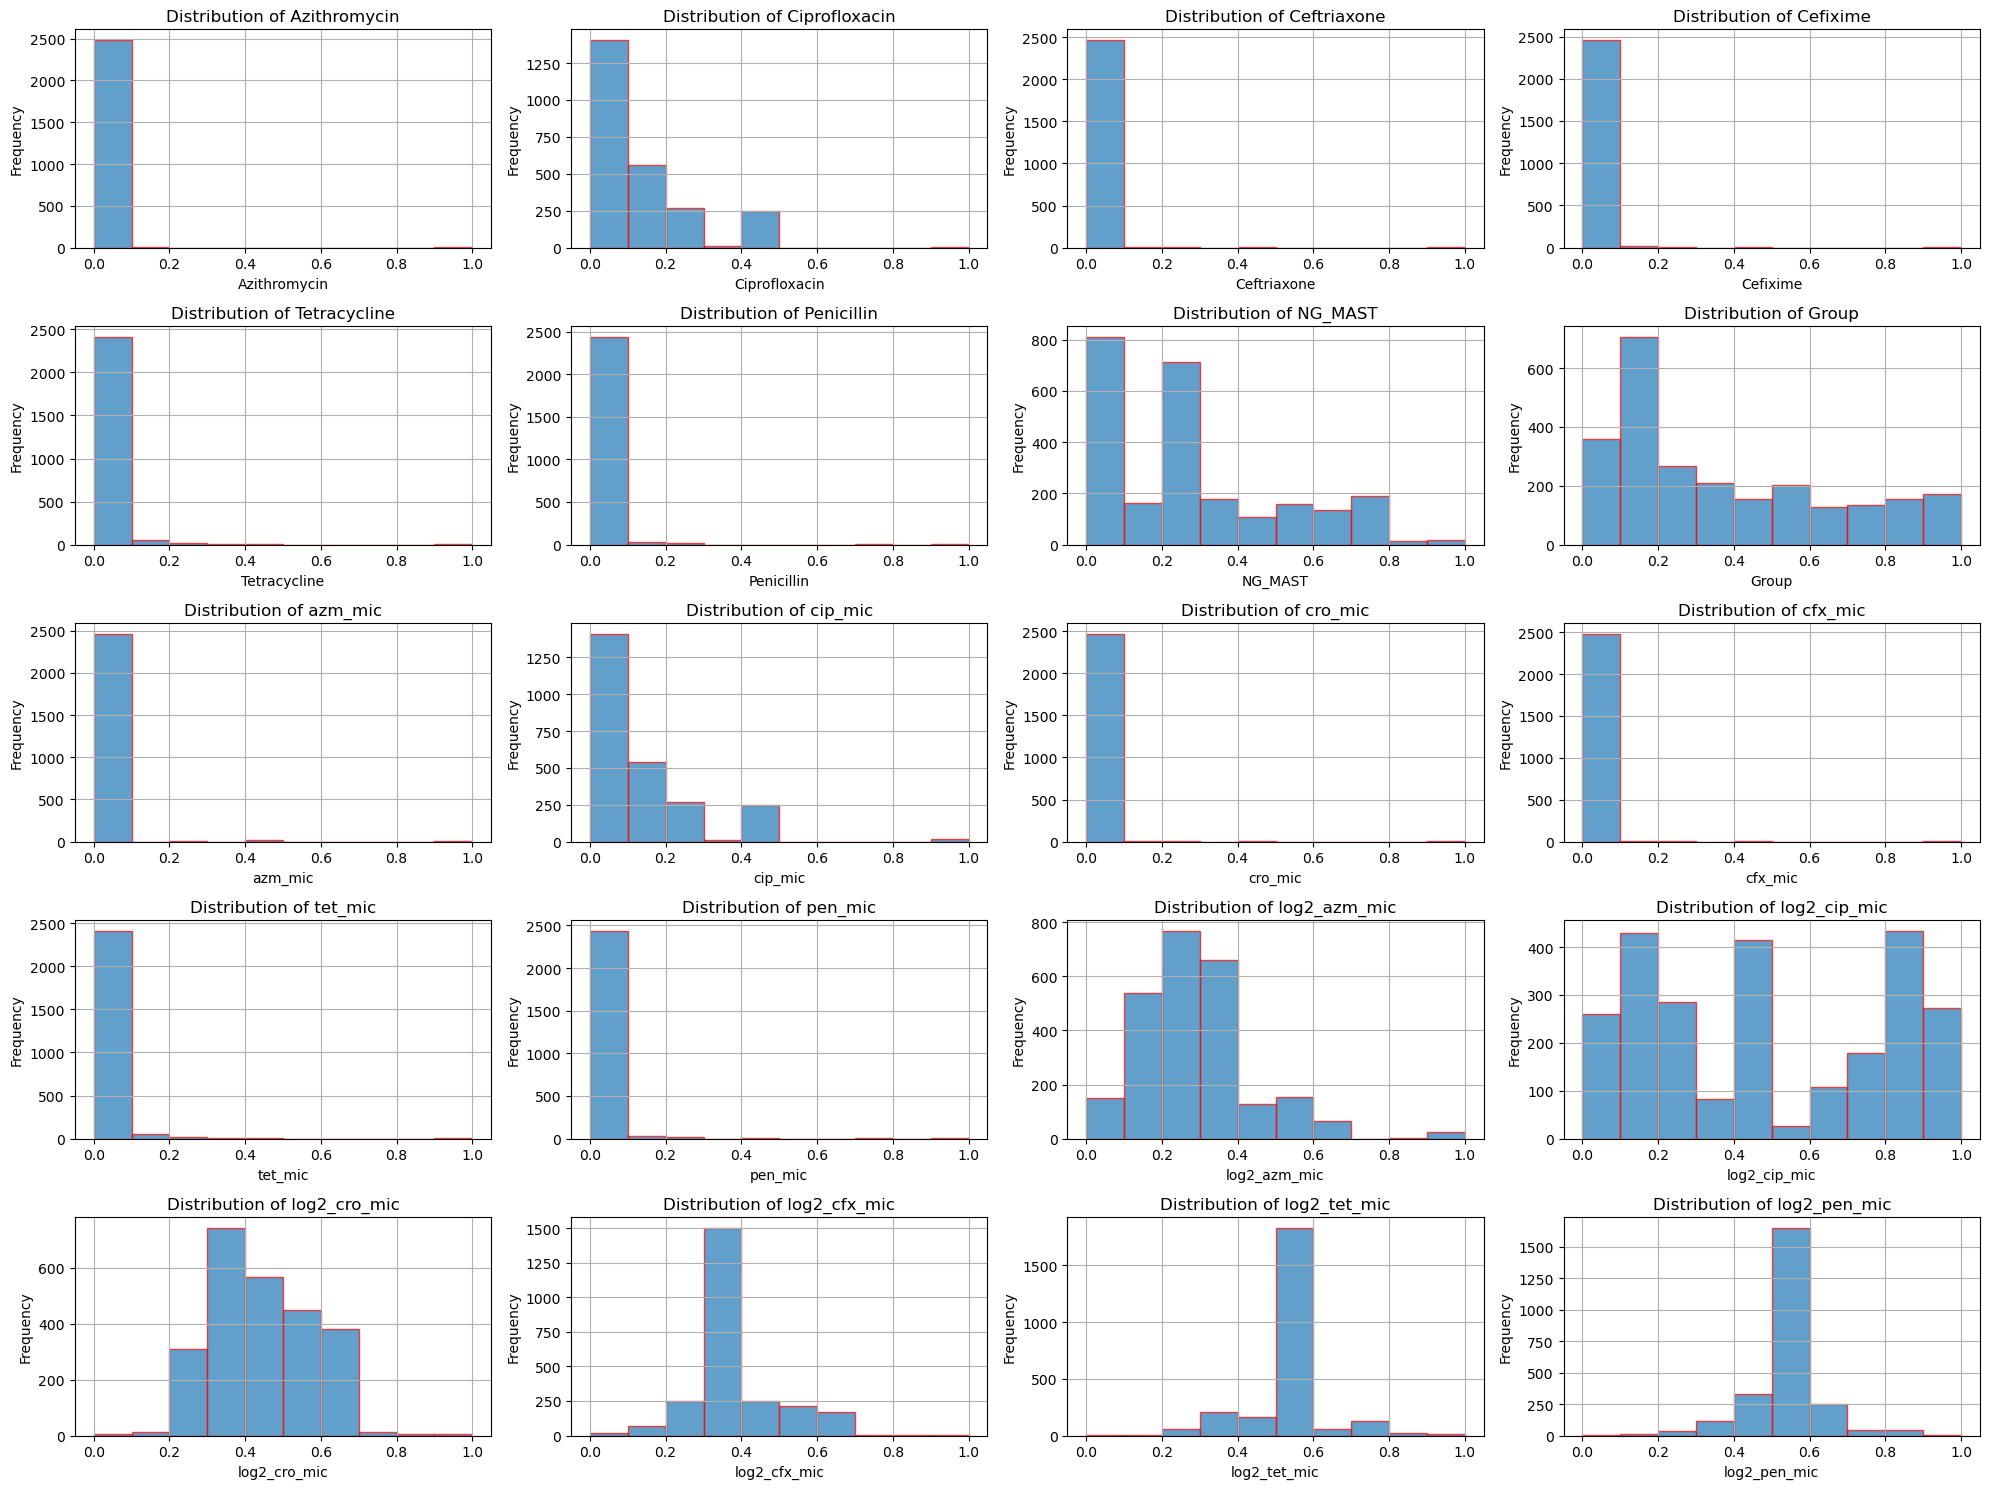

In [21]:
fig, axes = plt.subplots(5, 4, figsize=(20, 15))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    axes[i].hist(train_inputs[column], bins=10, edgecolor='red', alpha=0.7)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Multivariate Analysis (Show relationship of individual variables wrt to labels, pair plots and such) 



### Show impact of numerical features on the 3 different labels

4. Visualize numerical features plotted against the different labels

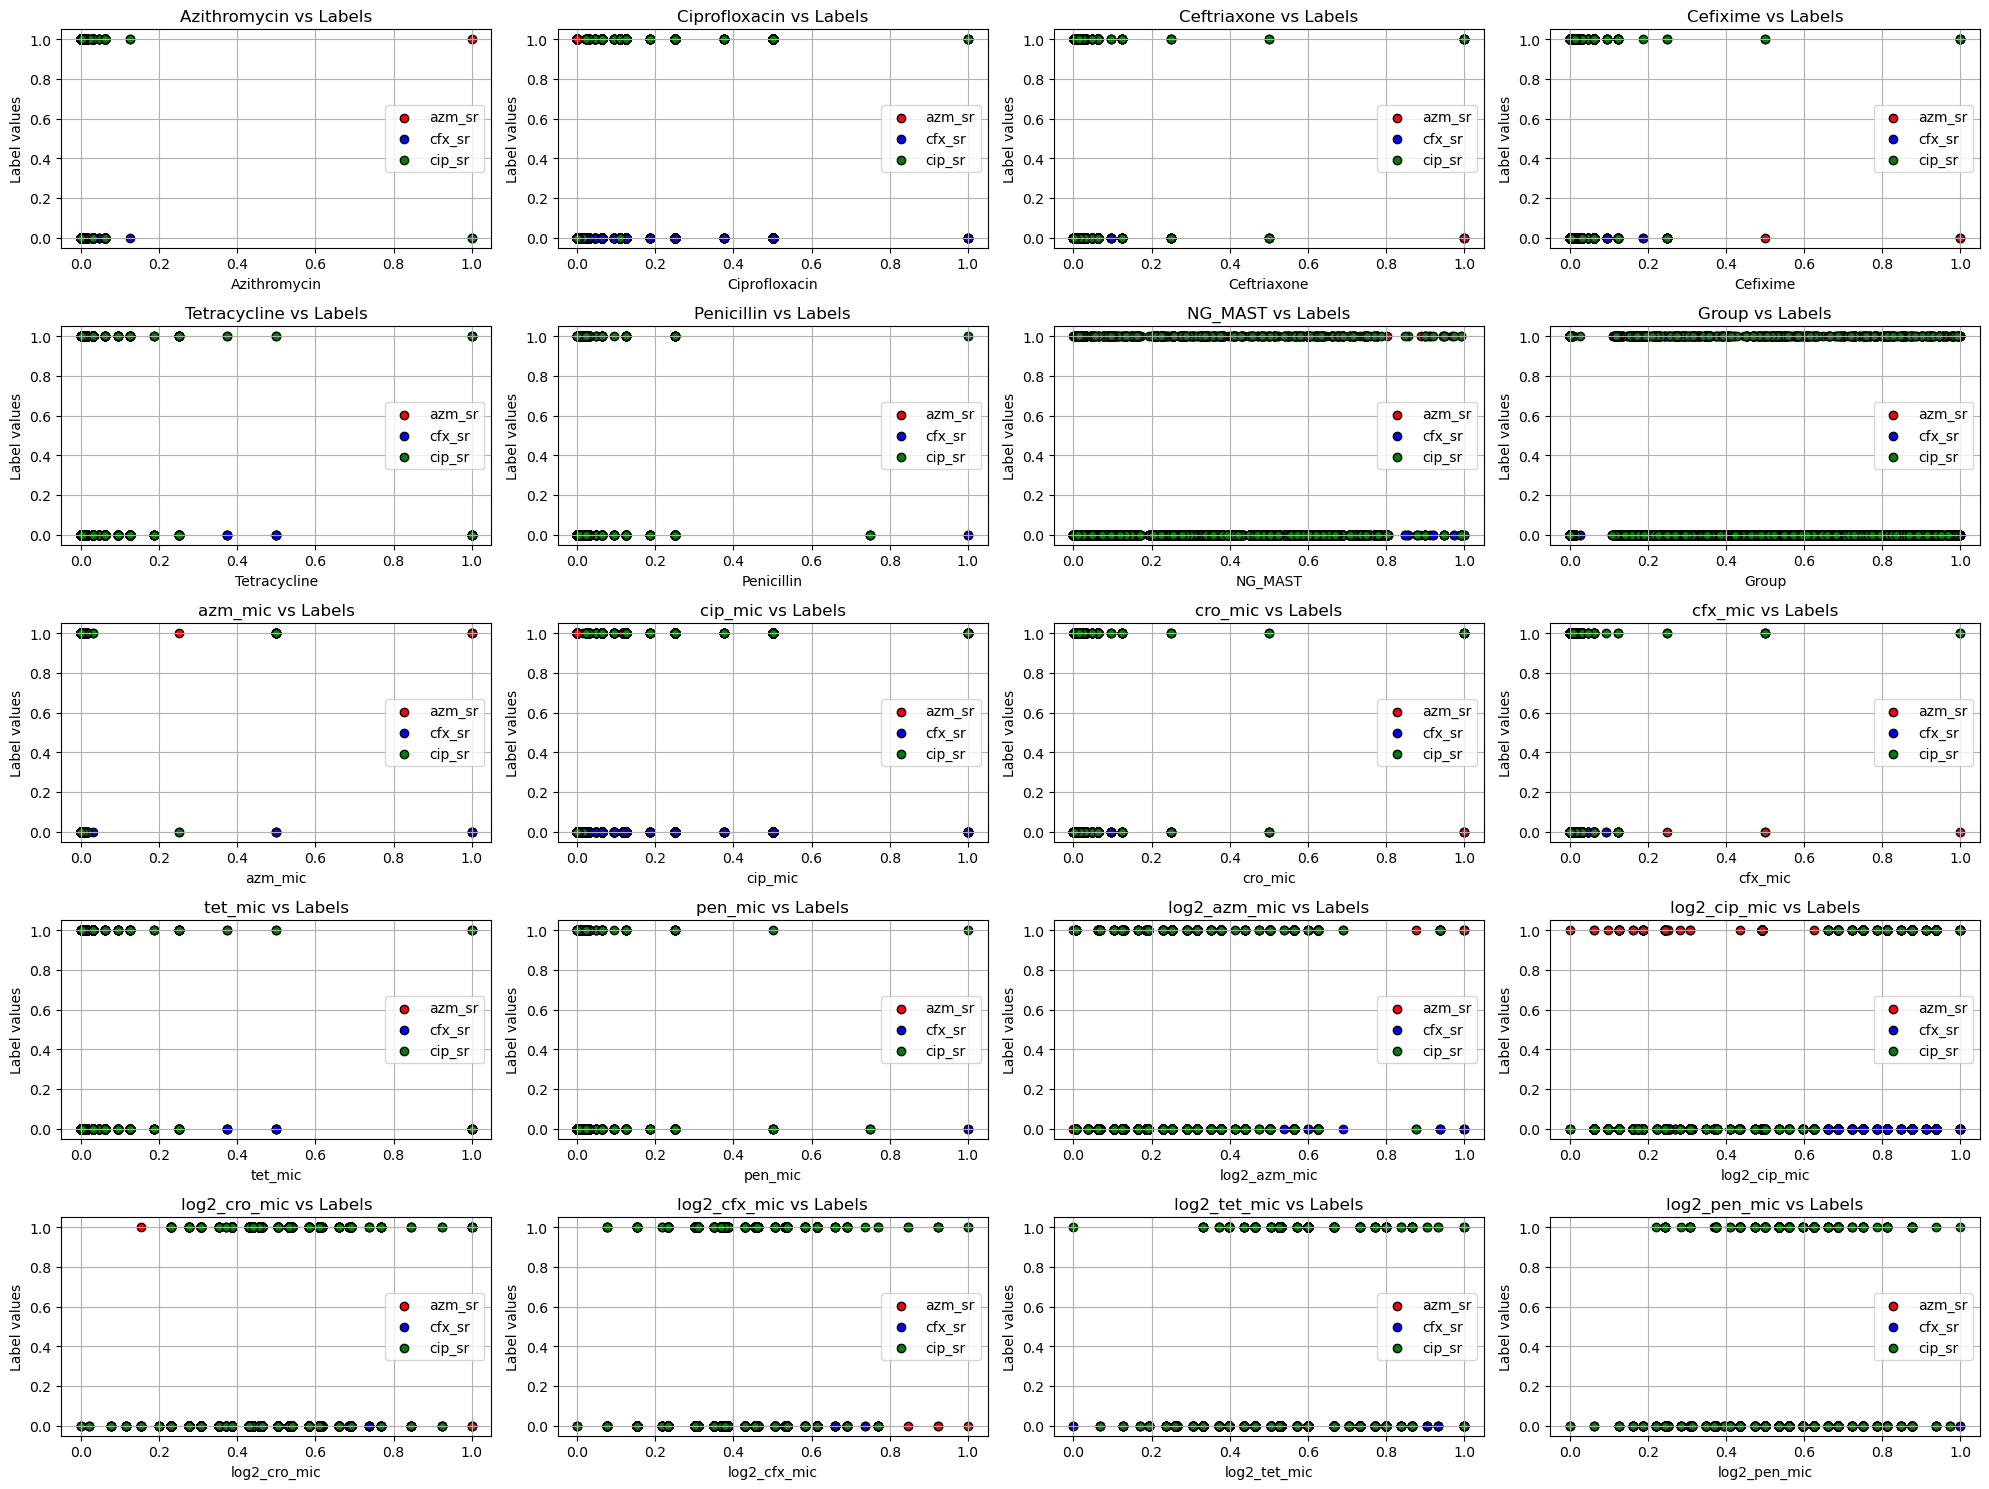

In [22]:
fig, axes = plt.subplots(5, 4, figsize=(20, 15))


axes = axes.flatten()

for i, column in enumerate(numeric_columns):

    axes[i].scatter(train_inputs[column], train_inputs["azm_sr"], label='azm_sr', color='red', edgecolor='black')
    
    axes[i].scatter(train_inputs[column], train_inputs["cfx_sr"], label='cfx_sr', color='blue', edgecolor='black')

    axes[i].scatter(train_inputs[column], train_inputs["cip_sr"], label='cip_sr', color='green', edgecolor='black')

    axes[i].set_title(f'{column} vs Labels')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Label values')
    axes[i].grid(True) #Qol

    axes[i].legend()


plt.tight_layout()
plt.show()

## Correlation Analysis (Pearson, Spearman, etc)


5. Calculate and visualize each feature's impact on the label

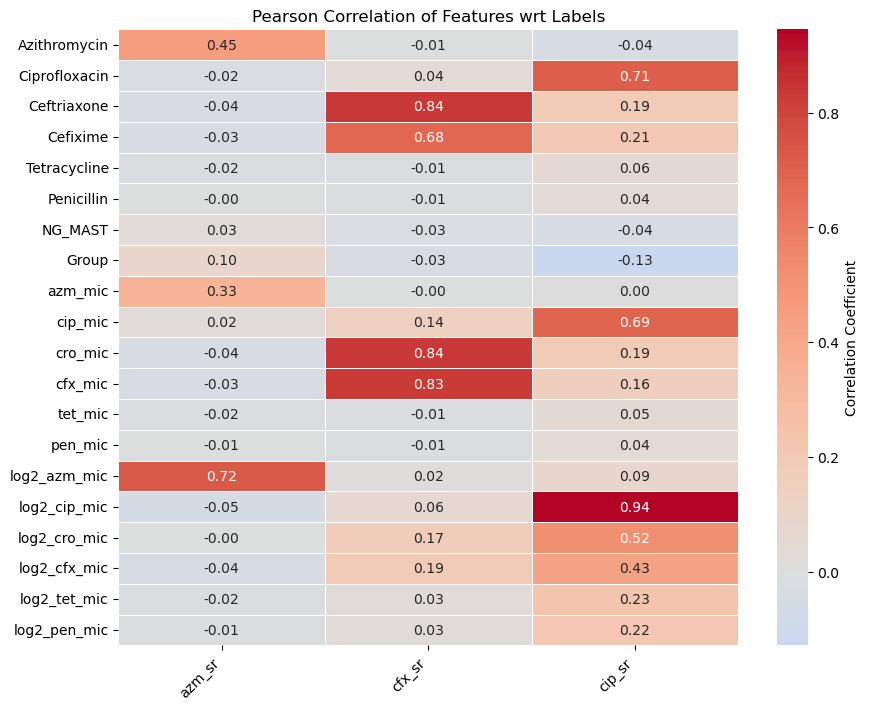

In [23]:
label_columns = ['azm_sr', 'cfx_sr', 'cip_sr'] #Separated labels from numerical columns
stacked = numeric_columns + label_columns 
stackedDF = train_inputs[stacked].astype(float) 


correlation_matrix = stackedDF.corr() #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html   !!! Pearson by default
feature_label_corr = correlation_matrix.loc[numeric_columns, label_columns] #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html


plt.figure(figsize=(10, 8)) #Need to use seaborn. idk how to make matplotlib heatmap
sns.heatmap(
    feature_label_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Correlation Coefficient'} 
)
plt.title("Pearson Correlation of Features wrt Labels")
plt.xticks(rotation=45, ha='right') #Qol

plt.show()




# Extract important features
6. Look at correlation visualization and record most impactful features and separate them by label. Threshold > +0.05

In [24]:
impact_threshold = 0.05


feature_impact = {}

for label in label_columns:
    correlations = feature_label_corr[label]

    significant_features = correlations[abs(correlations) > impact_threshold].index.tolist() #abs because negative impacts matter too
    feature_impact[label] = significant_features


for label, features in feature_impact.items():
    print(f"Impactful features for {label}")
    for feature in features:
        corr_value = feature_label_corr.loc[feature, label]
        print(f" * {feature}: Correlation = {corr_value}")

#print(feature_impact)

#feature_impact will be dictionary of all impactful features for every label (key)

Impactful features for azm_sr
 * Azithromycin: Correlation = 0.45246046466751616
 * Group: Correlation = 0.09546140994798231
 * azm_mic: Correlation = 0.33309874367227105
 * log2_azm_mic: Correlation = 0.7249744667358493
 * log2_cip_mic: Correlation = -0.051520854139286525
Impactful features for cfx_sr
 * Ceftriaxone: Correlation = 0.8369671869168048
 * Cefixime: Correlation = 0.6775234023402171
 * cip_mic: Correlation = 0.14119023870077058
 * cro_mic: Correlation = 0.8369508121198919
 * cfx_mic: Correlation = 0.8257728774892811
 * log2_cip_mic: Correlation = 0.06215456778249806
 * log2_cro_mic: Correlation = 0.1663635475783556
 * log2_cfx_mic: Correlation = 0.1894199429007991
Impactful features for cip_sr
 * Ciprofloxacin: Correlation = 0.7106458503695197
 * Ceftriaxone: Correlation = 0.19405191719129145
 * Cefixime: Correlation = 0.21475438981709716
 * Tetracycline: Correlation = 0.05991547593714425
 * Group: Correlation = -0.1286073397391039
 * cip_mic: Correlation = 0.6896004321830

## Outlier Detection (box plots, then remove outliers)

6. Replace outliers with average of that column. Ensure it is numerical column

training data


/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put 

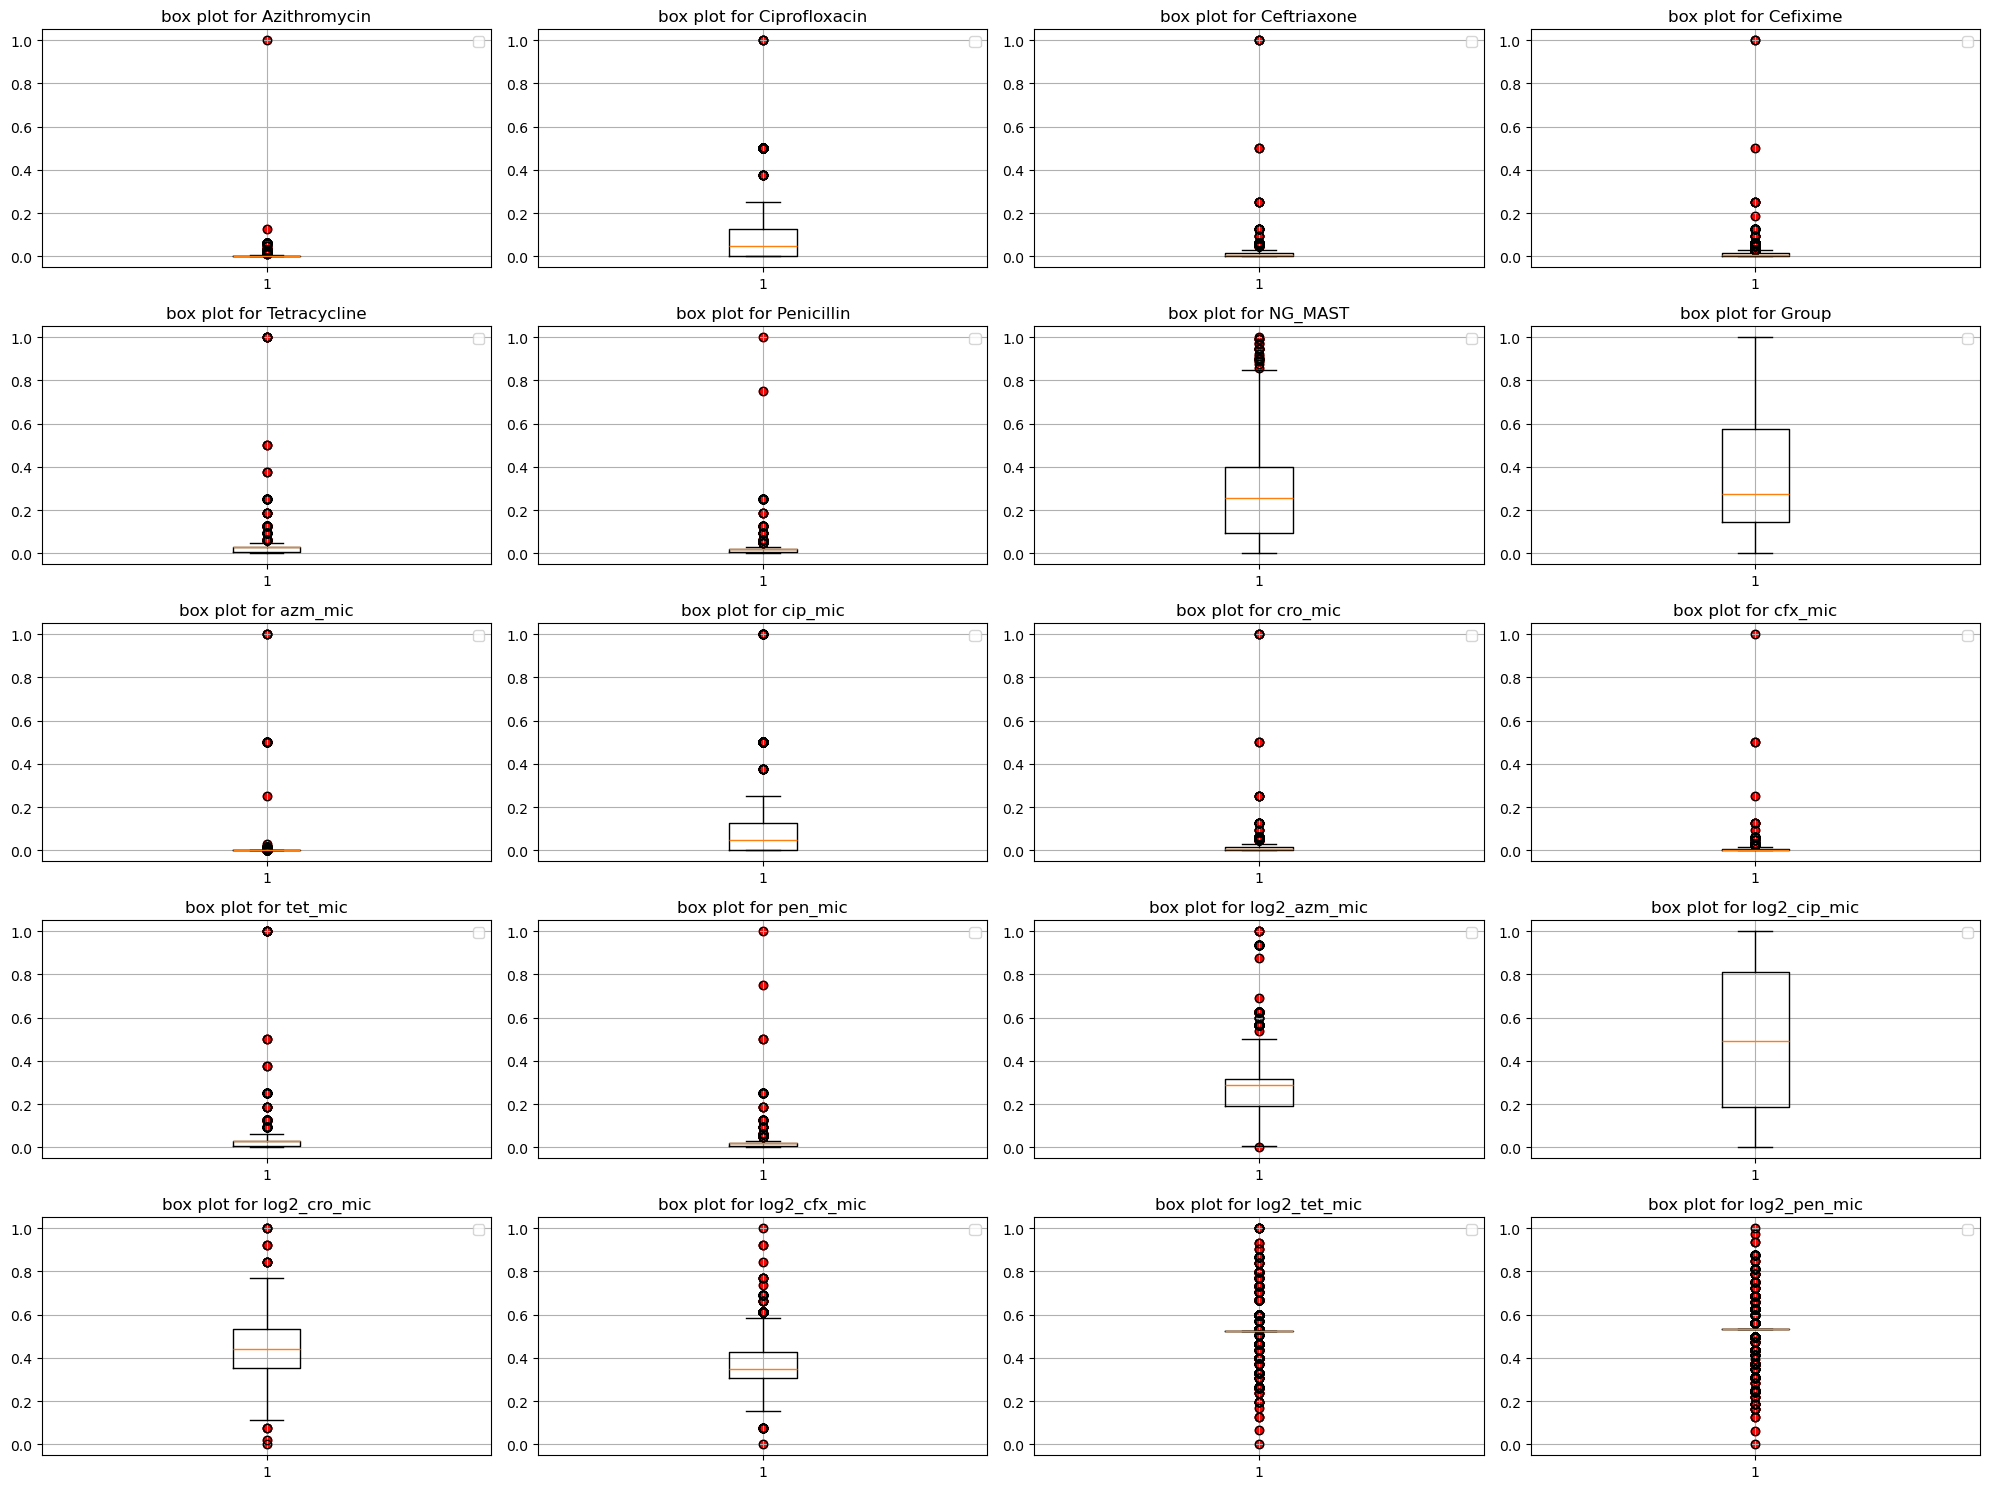

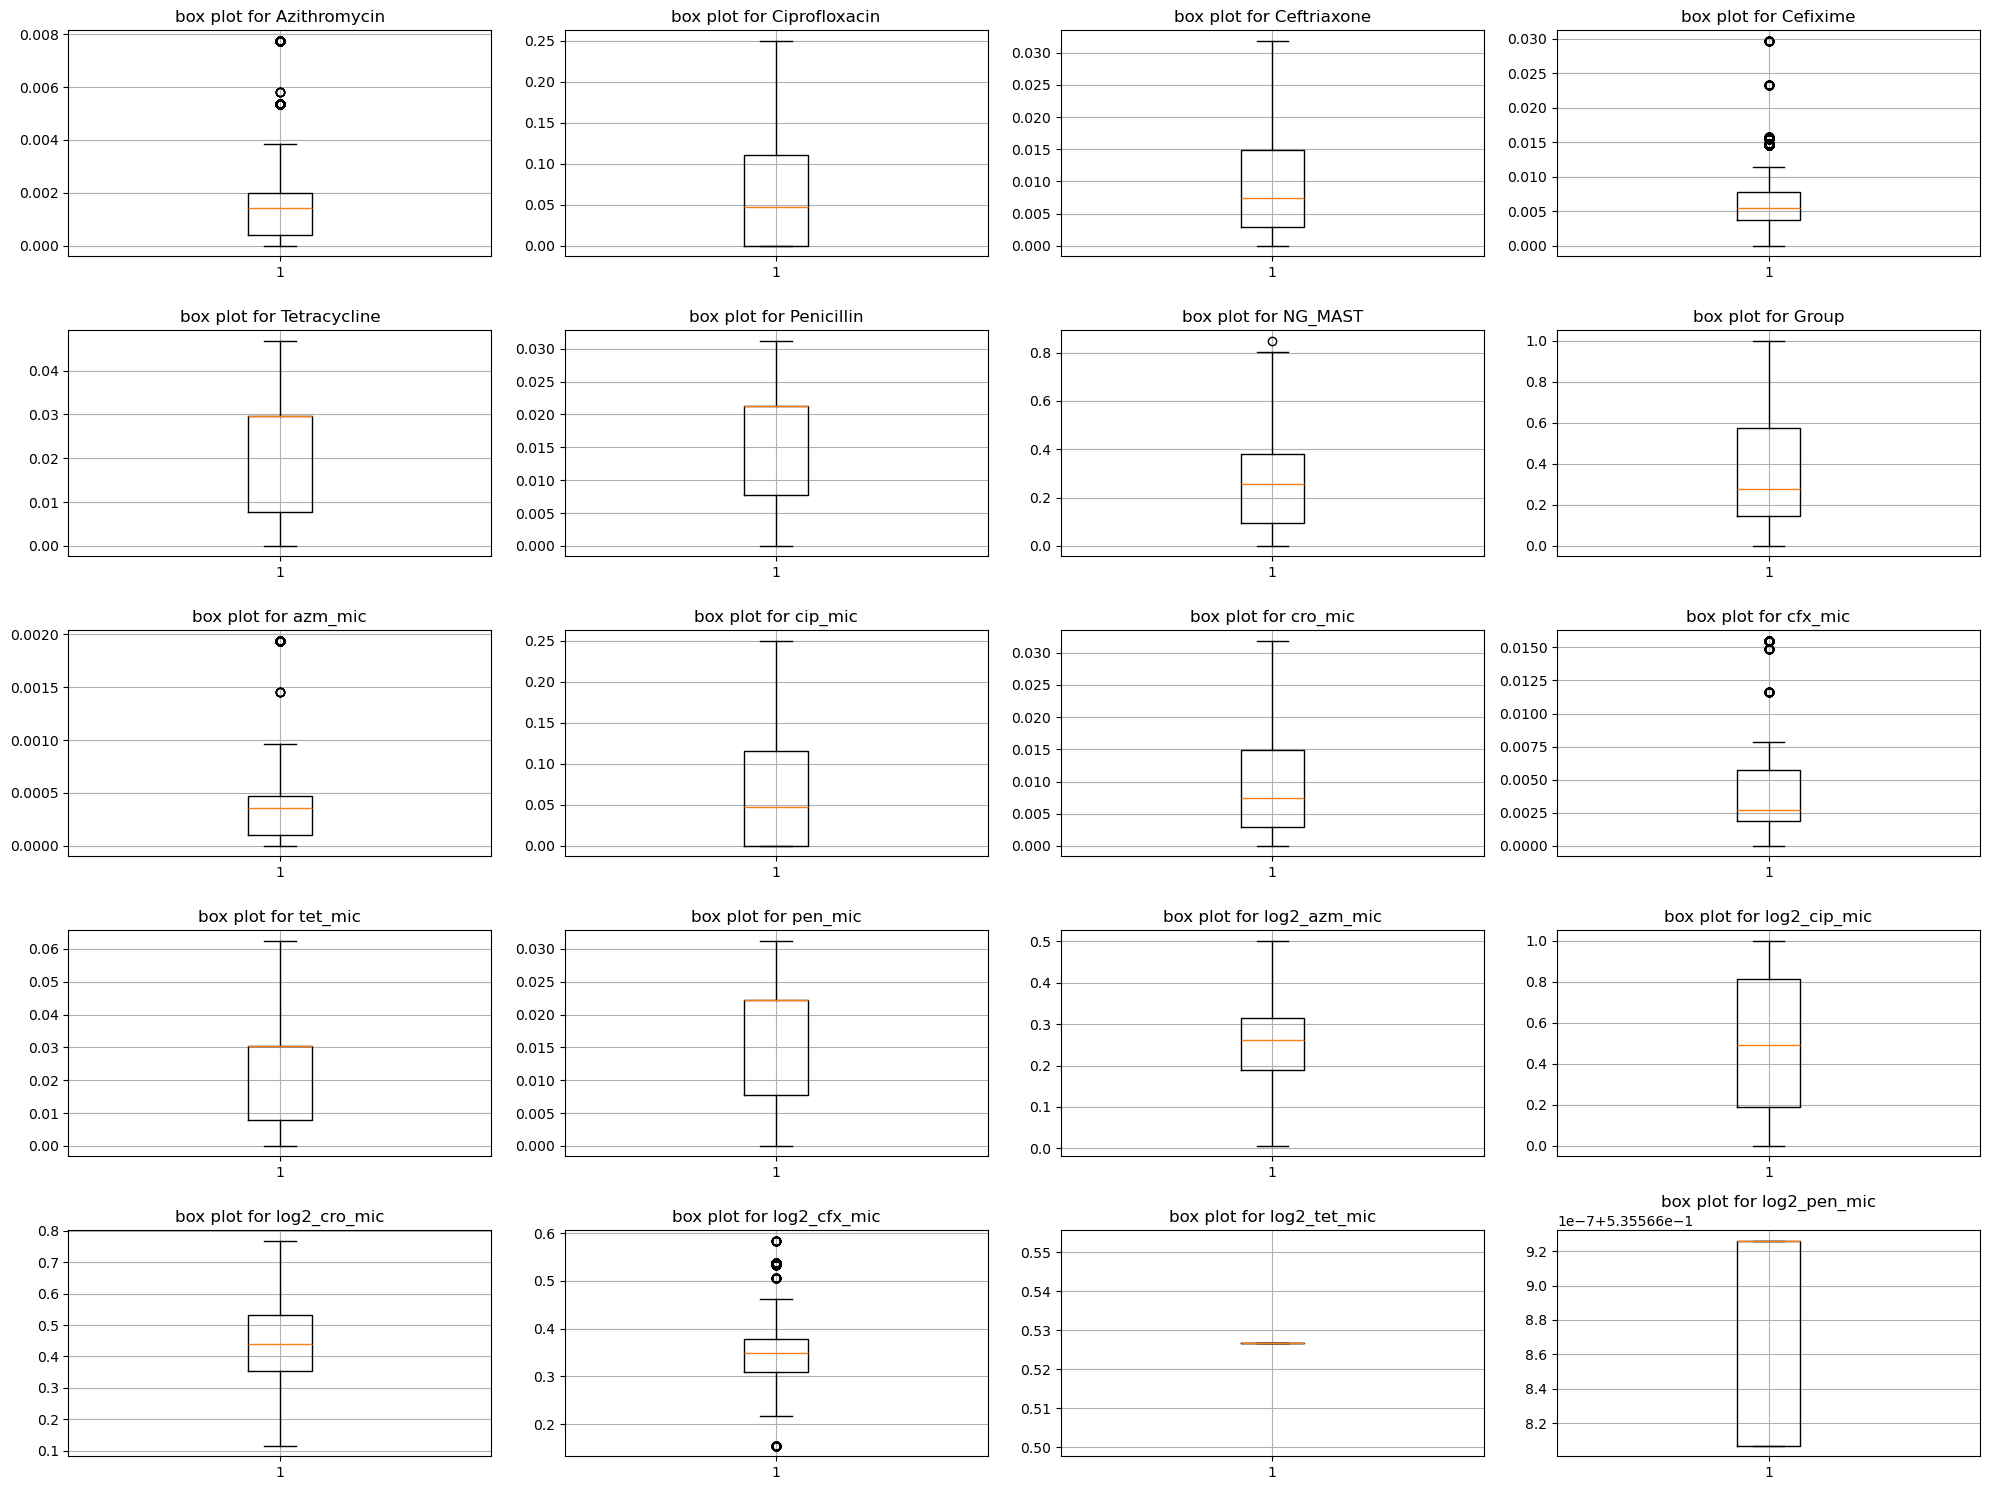

testing data


/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()
/tmp/ipykernel_40665/3145358541.py:26: UserWarning: No artists with labels found to put 

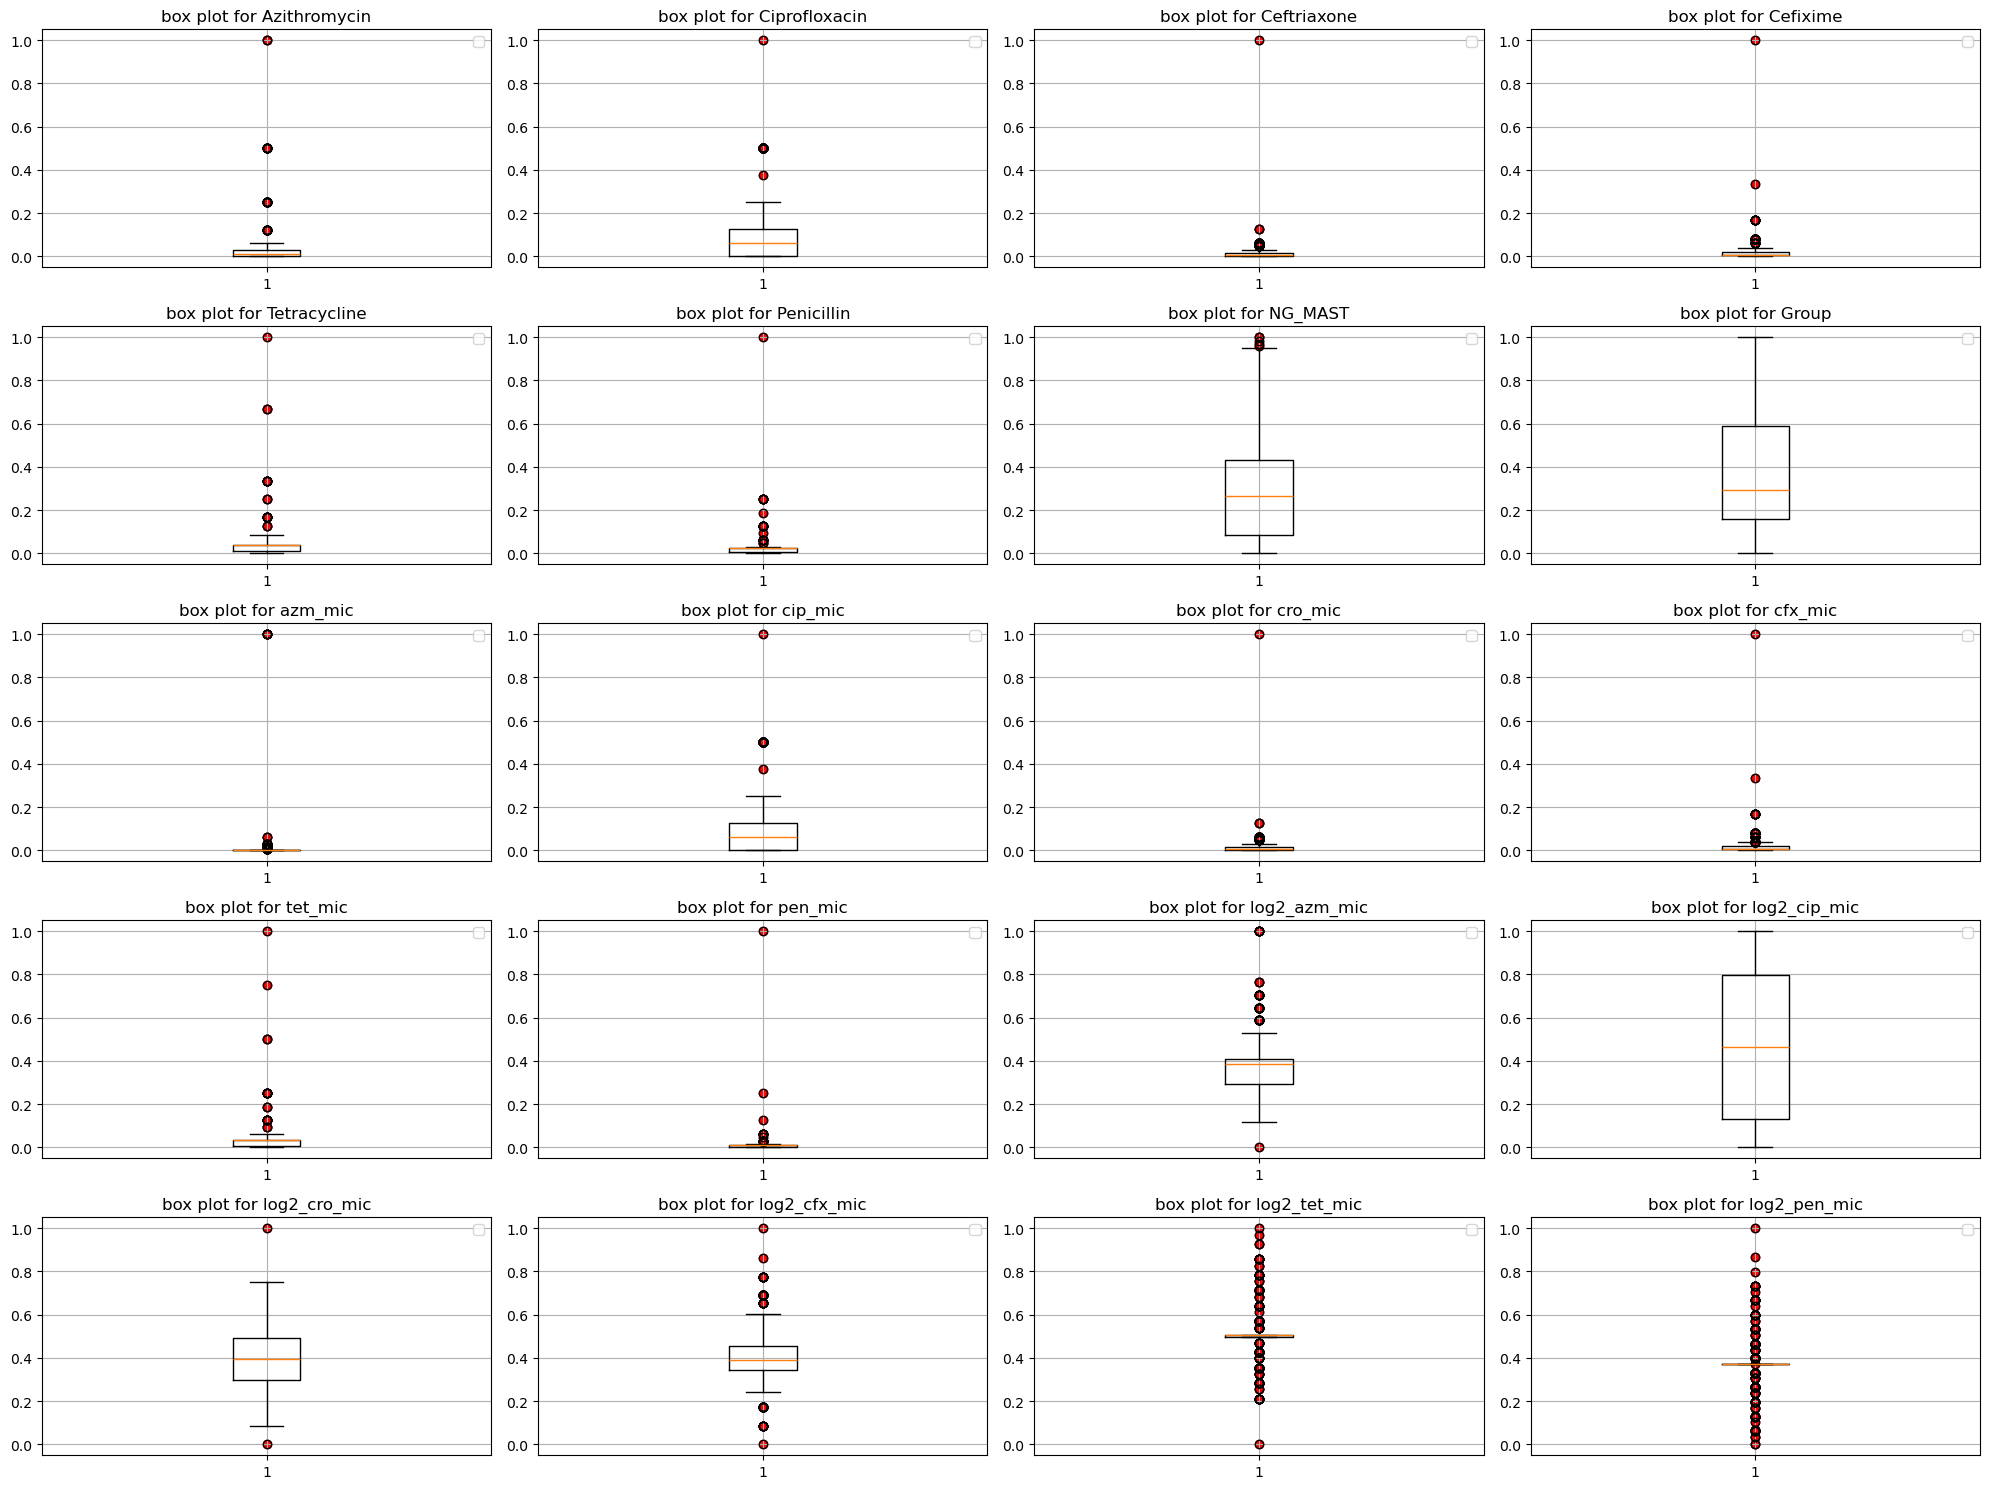

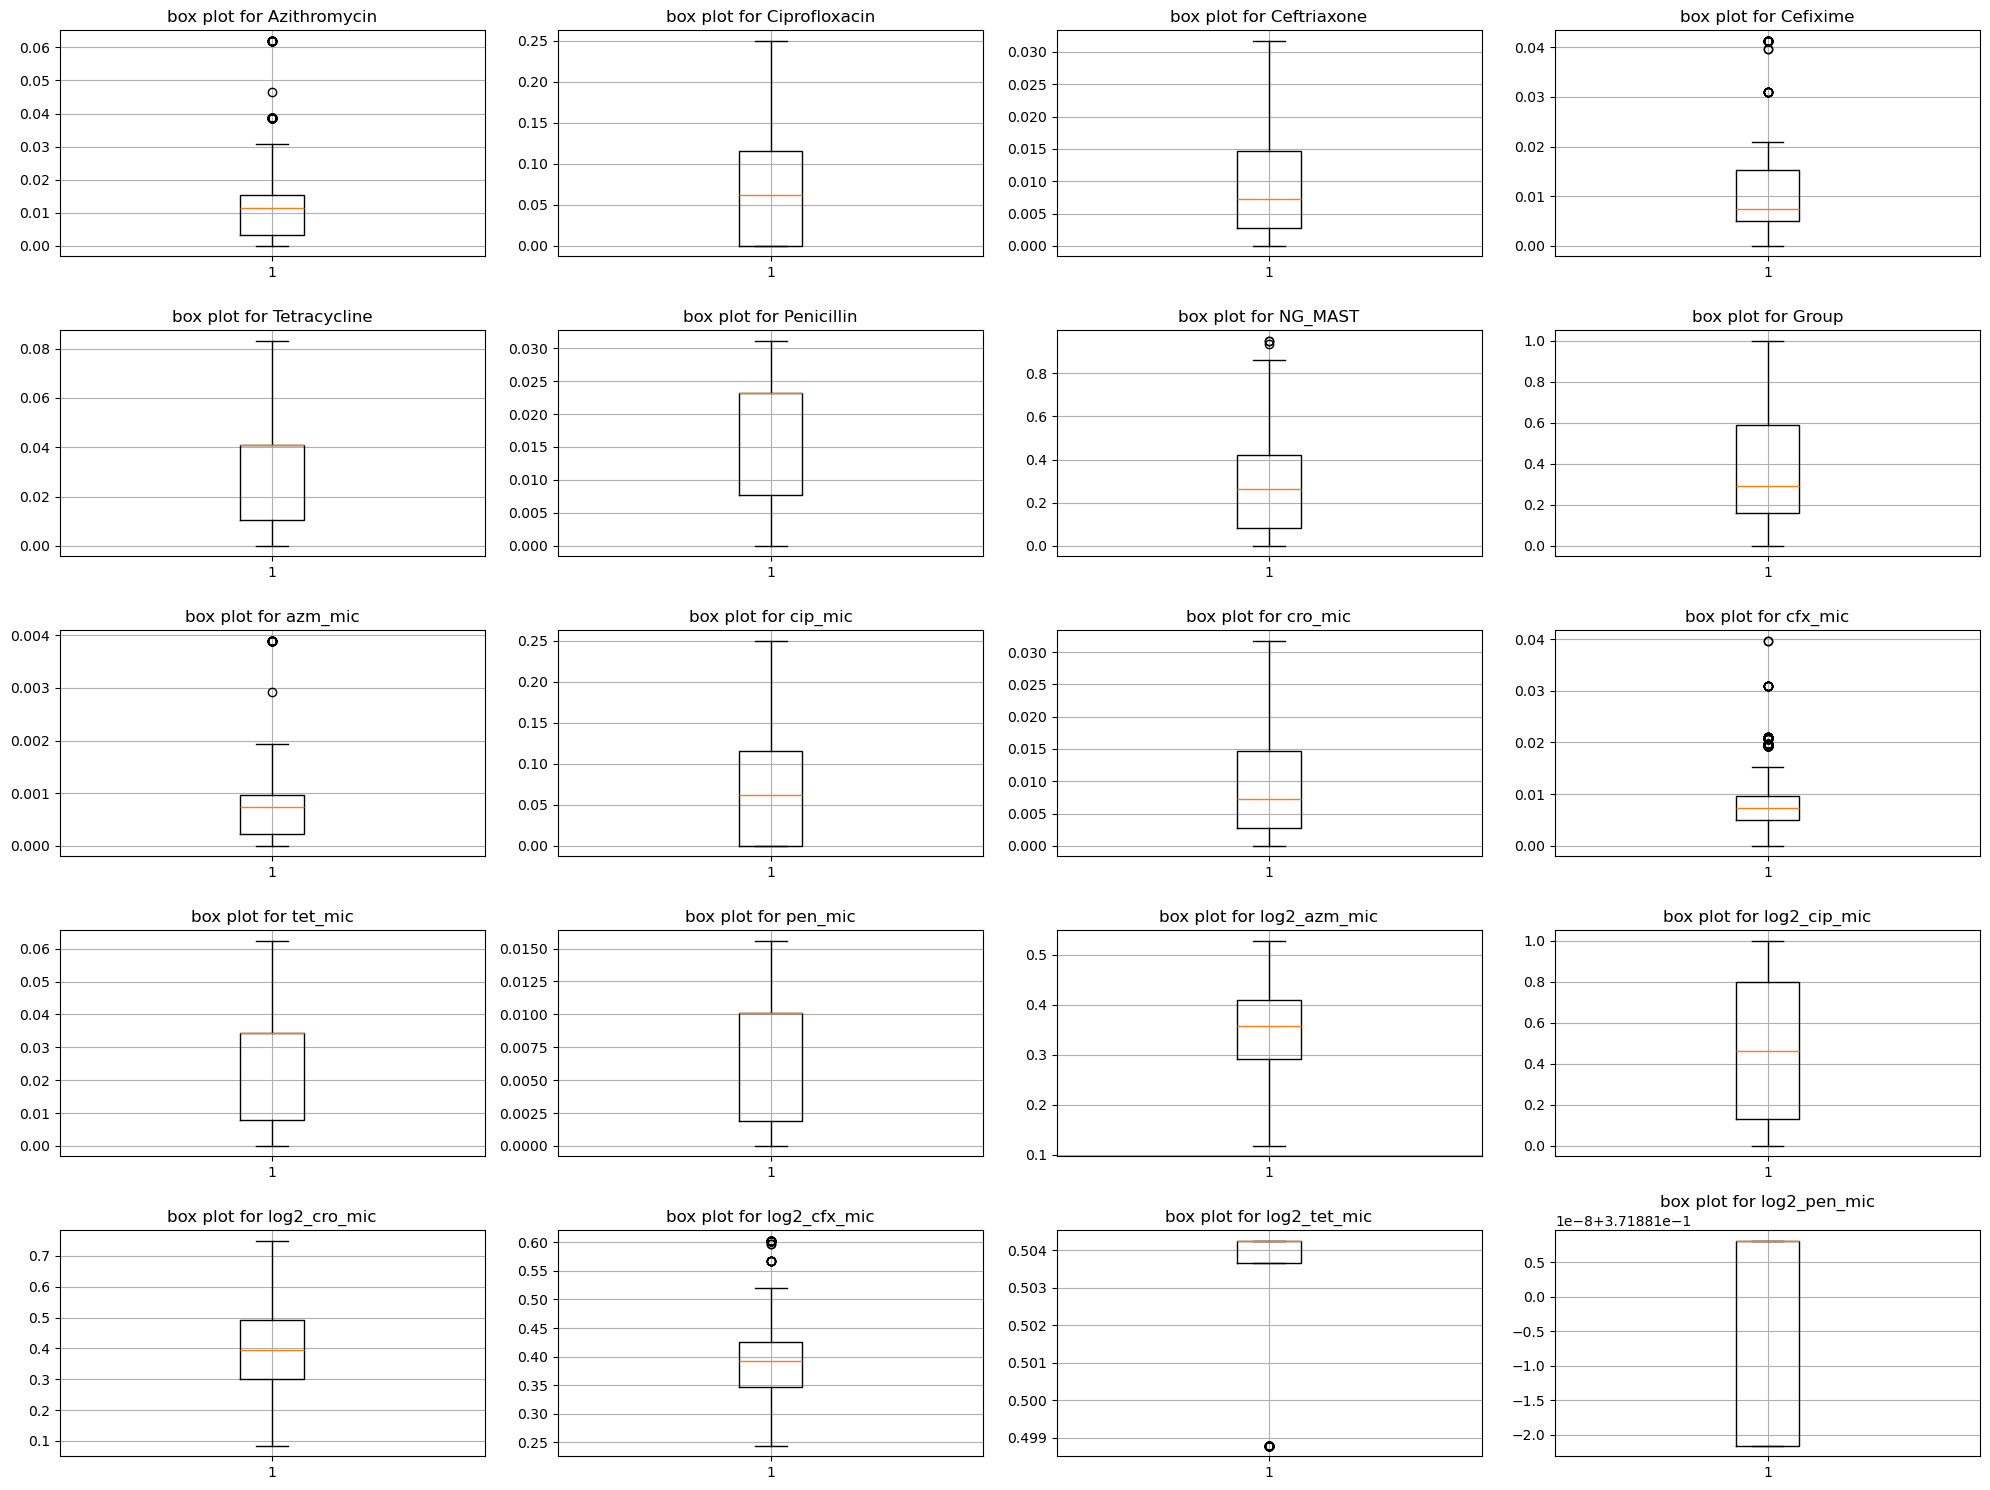

In [26]:

def outlier_detection(dataset):

    fig, axes = plt.subplots(5, 4, figsize=(20, 15))

    axes = axes.flatten()
    for i, col in enumerate(numeric_columns):
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3-Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = dataset[col][(dataset[col] < lower_bound) | (dataset[col] > upper_bound)]
        non_outliers = dataset[col][(dataset[col] >= lower_bound) & (dataset[col] <= upper_bound)]
        mean = non_outliers.mean()        
        
        outliers.size, dataset[col].size
        axes[i].boxplot(dataset[col])
        axes[i].scatter([1]*len(outliers), outliers, color='red')
        #sns.boxplot(outliers)
        axes[i].set_title("box plot for "+ col)
        dataset[col] = dataset[col].apply(lambda x: mean if (x < lower_bound or x > upper_bound) else x)

        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(5, 4, figsize=(20, 15))

    axes = axes.flatten()
    for i, col in enumerate(numeric_columns):
        axes[i].boxplot(dataset[col])
        #sns.boxplot(outliers)
        axes[i].set_title("box plot for "+ col)
        dataset[col].apply(lambda x: mean if (x < lower_bound or x > upper_bound) else x)
    
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

print("training data")
outlier_detection(train_inputs)
print("testing data")
outlier_detection(test_inputs)
